### Introduction
Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

This project is begins by:
- Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
- Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
- Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
- Plot the distribution of average ETA by hours. How can this plot be explained?
- BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

### Data Description
We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

- order_datetime - time of the order
- origin_longitude - longitude of the order
- origin_latitude - latitude of the order
- m_order_eta - time before order arrival
- order_gk - order number
- order_status_key - status, an enumeration consisting of the following mapping:
- 4 - cancelled by client,
- 9 - cancelled by system, i.e., a reject
- is_driver_assigned_key - whether a driver has been assigned
- cancellation_time_in_seconds - how many seconds passed before cancellation

The data_offers data set is a simple map with 2 columns:

- order_gk - order number, associated with the same column from the orders data set
- offer_id - ID of an offer

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load files
orders = pd.read_csv(r'C:\Users\Admin\Documents\#data analysis\2. Portfolio Project\data_orders.csv')
offers = pd.read_csv(r'C:\Users\Admin\Documents\#data analysis\2. Portfolio Project\data_offers.csv')

In [4]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [6]:
#inspect the data format and missing numbers in dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [7]:
#inspect the data format and missing numbers in dataset
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [8]:
# change order_datetime to only hour
orders['order_time'] = orders['order_datetime'].str.split(':').apply(lambda x: x[0])
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_time
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21


Merge the two datasets for easier analysis by merging on order_gk column 

In [9]:
df = orders.merge(offers,how='inner',on='order_gk')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_time,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,300050976275


In [10]:
# Replace values 4 and 9 with more interpretable value i.e., 'client cancelled'  and 'system cancelled' respectively
df['order_status_key'] = np.where(df['order_status_key'] == 4, 'client cancelled', 'system cancelled')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_time,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,client cancelled,1,198.0,18,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,0,128.0,20,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,0,128.0,20,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,0,128.0,20,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancelled,1,46.0,12,300050976275


In [11]:
# Replace values 1 and 0 with more interpretable value 'i.e., 'driver assigned' and 'driver not assigned'
df['is_driver_assigned_key'] = np.where(df['is_driver_assigned_key'] == 1, 'driver assigned', 'driver not assigned')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_time,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,client cancelled,driver assigned,198.0,18,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancelled,driver assigned,46.0,12,300050976275


Rename columns to be more informative

In [12]:
df.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'order_time', 'offer_id'],
      dtype='object')

In [13]:
cols = {'origin_longitude': 'longitude', 
        'origin_latitude': 'latitude', 
        'm_order_eta': 'ETA',
       'order_gk': 'order_id', 
        'order_status_key': 'order_status', 
        'is_driver_assigned_key':'is_driver_assigned',
        'cancellations_time_in_seconds': 'cancellations_time'}
df.rename(columns=cols, inplace=True)
df

,order_datetime,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellations_time,order_time,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,client cancelled,driver assigned,198.0,18,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancelled,driver not assigned,128.0,20,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancelled,driver assigned,46.0,12,300050976275
...,...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,client cancelled,driver not assigned,43.0,12,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,client cancelled,driver not assigned,44.0,12,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,client cancelled,driver not assigned,36.0,13,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,client cancelled,driver assigned,34.0,13,300051648910


#### Exploratory Data Analysis

### Question 1

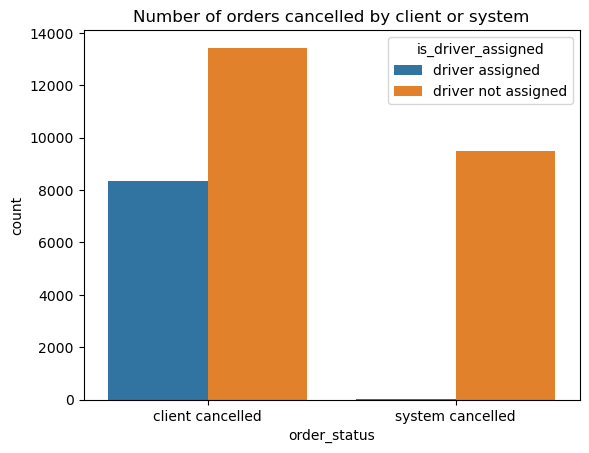

In [14]:
# 1. Plotting distribution of reasons for failure using two columns 'is_driver_assigned' and 'order_status'
sns.countplot(data=df, x='order_status', hue='is_driver_assigned')
plt.title('Number of orders cancelled by client or system')
plt.show()

In [15]:
# Checking the number of driver assigned for orders cancelled by the system as it did not show on the chart above
df[df['order_status']=='system cancelled'][['is_driver_assigned']].value_counts()

is_driver_assigned 
driver not assigned    9469
driver assigned           4
dtype: int64

It is observed that failed orders mostly are cancel by clients and mostly the orders have not been assigned a driver especially failed order cancel by system, implying that probably clients had waited too long be assigned a driver. 

### Question 2

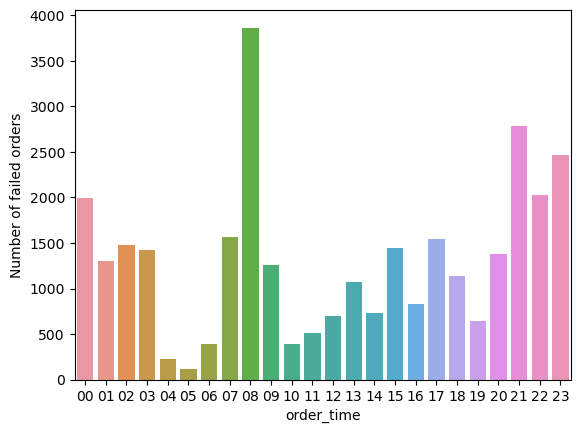

In [16]:
# 2. Ploting the distribution of failed orders by hours
sns.countplot(x=df['order_time'].sort_values())
plt.xlabel('order_time')
plt.ylabel('Number of failed orders')
plt.show()

From the bar chart above, it is observed that there is a highest failed orders occurred at 08:00, followed by 21:00 and 23:00

On below, failed orders are further investigated by hour and by category, to obtain deeper insights on the cancellations by category.

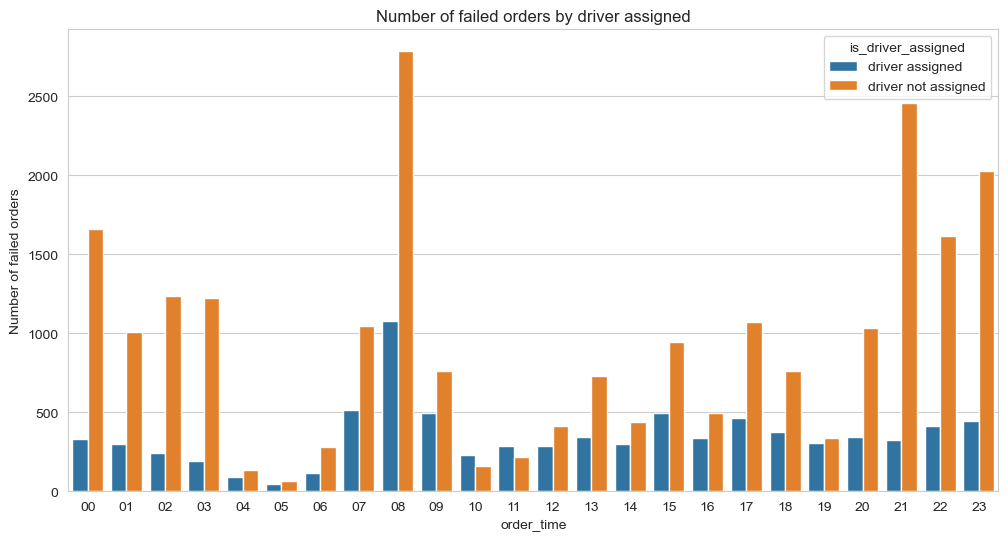

In [19]:
# Bar chart plotting by driver_ssigned category
sns.set_style('whitegrid')
fig = plt.subplots(figsize=(12,6))
sns.countplot(data = df, x=df['order_time'].sort_values(), hue='is_driver_assigned')
plt.xlabel('order_time')
plt.ylabel('Number of failed orders')
plt.title('Number of failed orders by driver assigned')
plt.show()

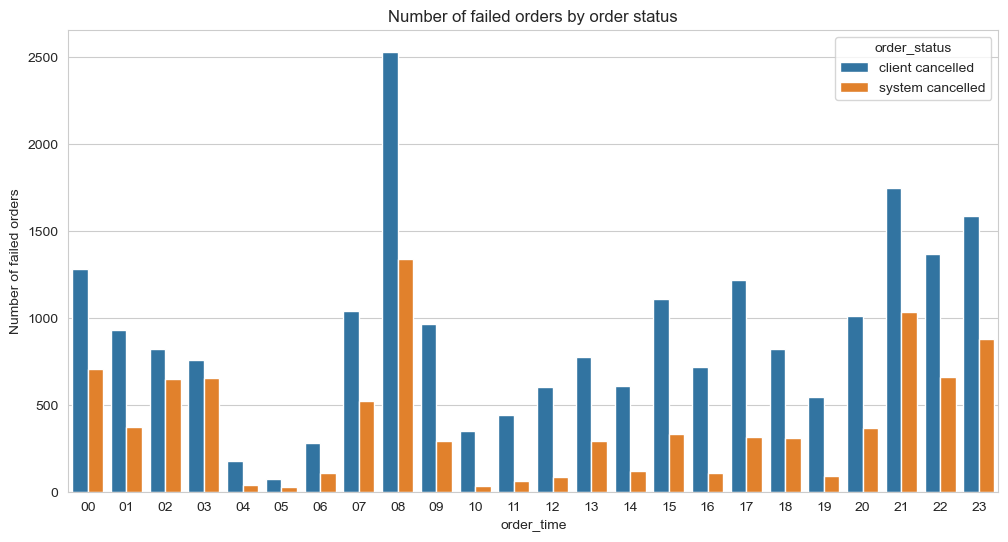

In [20]:
# Bar chart plotting by order_status category
sns.set_style('whitegrid')
fig = plt.subplots(figsize=(12,6))
sns.countplot(data = df, x=df['order_time'].sort_values(), hue='order_status')
plt.xlabel('order_time')
plt.ylabel('Number of failed orders')
plt.title('Number of failed orders by order status')
plt.show()

From the breakdown of the above bar chart, it is seen that the highes cancelation accross all categories indeed occurred at 8:00.

### Question 3

In [32]:
# 3. Ploting the average time to cancellation with and without driver
df3 = pd.DataFrame(df.groupby(['order_time','is_driver_assigned'])['cancellations_time'].mean())
df3.head()

cancellations_time
order_time is_driver_assigned                     
00         driver assigned              276.082822
           driver not assigned          115.126437
01         driver assigned              296.312081
           driver not assigned          100.593997
02         driver assigned              301.466667

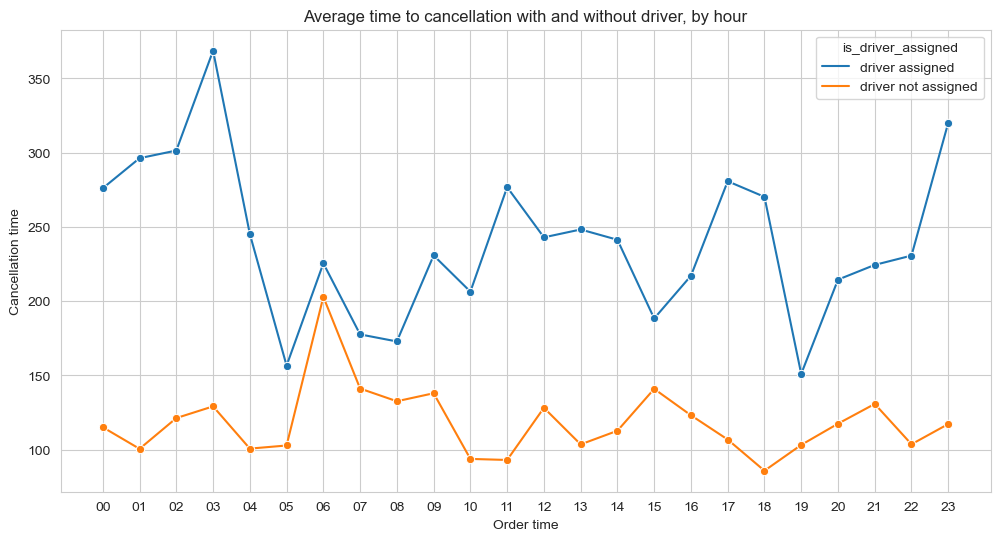

In [39]:
sns.set_style('whitegrid')
fig = plt.subplots(figsize=(12,6))
sns.lineplot(data = df3, x='order_time', y='cancellations_time', hue='is_driver_assigned', marker='o')
plt.xlabel('Order time')
plt.ylabel('Cancellation time')
plt.title('Average time to cancellation with and without driver, by hour')
plt.show()

The average time to cancellation for orders with driver assigned are higher than driver not assigned. The peak occurred at 3:00, in which orders cancelled by the client with a driver assigned, implying that the client have waited too long for the driver.

### Question 4

Text(0, 0.5, 'Estimated time of Arrival')

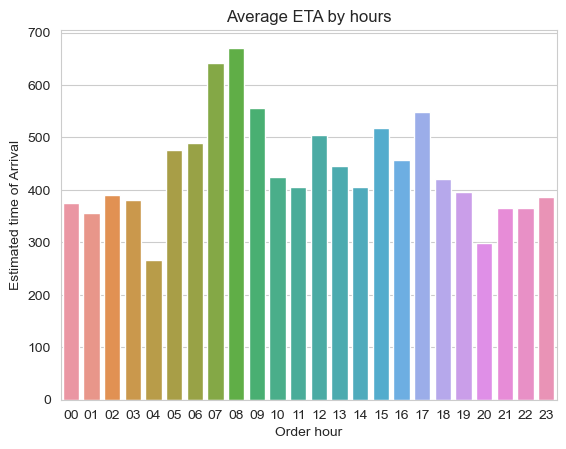

In [54]:
# 4. Plot the distribution of average ETA by hours
df4 = pd.DataFrame(df.groupby('order_time')['ETA'].mean().reset_index())
sns.barplot(x=df4['order_time'], y=df4['ETA'])
plt.title('Average ETA by hours')
plt.xlabel('Order hour')
plt.ylabel('Estimated time of Arrival')

The trend of bar charts on above is closely matched with the count of failed orders performed on question 2. In this case, this indicates that the number of failed orders increase as the average estimated arrival time increase. 

### Conclusion:
It is observed that a high number of client cancelled their order before a driver was assigned, implying that probably clients had waited too long be assigned a driver and decided an alternative transportation.

The chart on above chearly showing that the highest number of failed orders occurred at 08:00, followed by 21:00 and 23:00. And this evidence accross all categories i.e., (1) driver assigned or not assigned and (2) cancellation by client or system.

The average time to cancellation for orders with driver assigned are higher than driver not assigned. The peak occurred at 3:00, in which orders cancelled by the client with a driver assigned, implying that the client have waited too long for the driver.

Number of failed orders increase by increase of ETAs, with the highest ETAs happening at 08:00. And the pattern is in line with count of failed orders by hour.

##### Recommendations to reduce cancellations:
- Increase driver to reduce waiting time especially at 07:00 to 08:00 and 16:00 to 17:00 as these time within the rush-hour where clients catch a ride to work or from work respectively.
- A reasonable business strategy would be incentivize the drivers by increasing the riding fares, thus making more rides available and reducing ETAs. 